In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import talib
from sklearn.model_selection import train_test_split

In [2]:
data=yf.download('0017.hk','2018-01-01','2022-04-09')
# data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,47.119999,47.759998,46.320000,47.439999,38.060638,5099488
2018-01-03,47.360001,47.680000,47.040001,47.439999,38.060638,3323916
2018-01-04,47.599998,47.919998,47.360001,47.919998,38.445736,3611376
2018-01-05,47.919998,50.560001,47.840000,49.599998,39.793583,11946129
2018-01-08,49.360001,50.000000,48.799999,49.279999,39.536846,5084424
...,...,...,...,...,...,...
2022-04-01,31.850000,32.200001,31.500000,32.150002,32.150002,2053614
2022-04-04,32.150002,32.400002,31.700001,32.400002,32.400002,1631328
2022-04-06,32.450001,32.450001,31.900000,32.299999,32.299999,3053935


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
target=data['Prediction']

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_67958/402952793.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished

[2022-04-13 19:48:38] Features: 1/10 -- score: 0.8733703888062274[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.0s finished

[2022-04-13 19:48:40] Features: 2/10 -- score: 0.8783352505779133[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapse

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=10,
                          n_jobs=-1, scoring='r2', verbose=2)

In [5]:
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=target
data_val=data[-100:]
data=data[:-100]
sc = MinMaxScaler(feature_range = (-1, 1))
X=data.drop('Prediction',1).values
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(735, 10) (735,) (184, 10) (184,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_67958/1151953013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=target
/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_67958/1151953013.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop('Prediction',1).values


In [6]:
clf = RandomForestRegressor()

In [7]:
model = clf.fit(X_train, y_train)

In [8]:
y_pred=model.predict(X_test)

In [9]:
y_pred

array([34.79130047, 37.3102002 , 37.08250004, 36.89700001, 36.92510025,
       38.99399952, 40.2203997 , 39.93719997, 40.35549919, 39.86040024,
       39.56160011, 37.78289989, 38.14380047, 38.58300003, 39.28349972,
       39.67950001, 40.11839993, 40.06399979, 40.13969948, 40.26739983,
       40.09629955, 40.59599998, 39.83509975, 39.83839989, 39.7742997 ,
       40.59580002, 39.28560017, 37.47279957, 38.08310051, 37.89400036,
       38.66779976, 40.2902    , 40.27189953, 40.28569988, 40.79430027,
       40.2182996 , 40.75360008, 40.8474004 , 40.6635997 , 42.69620018,
       42.29140007, 41.62739983, 42.40800022, 42.67840019, 41.71099987,
       42.09120003, 41.56940002, 41.45789989, 41.73380001, 41.91699993,
       41.81899994, 41.67150032, 40.60850063, 40.36069962, 40.87740059,
       41.43450043, 41.60919979, 42.38160038, 41.56570026, 41.40480034,
       40.38630051, 40.42159992, 40.56449986, 41.20360031, 41.05040054,
       40.9928006 , 40.84000027, 41.66890015, 42.15760017, 41.70

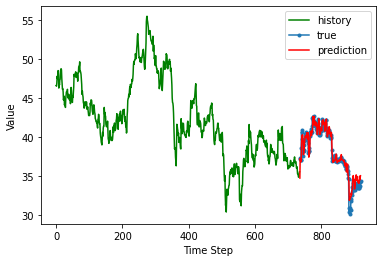

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
mean_absolute_percentage_error(y_test,y_pred)

0.014507240065504601

In [12]:
mean_squared_error(y_test,y_pred)

0.573891567028612

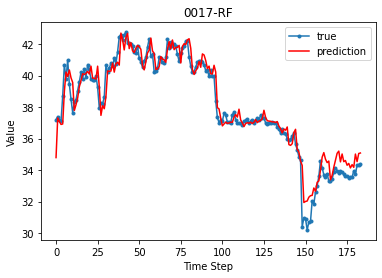

In [22]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('0017-RF')
plt.legend()
plt.show()

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.014507240065504601

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

0.7575563127772166

In [16]:
r2_score(y_test,y_pred)

0.941287889294267

In [17]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
# x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=clf.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_67958/2115332834.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


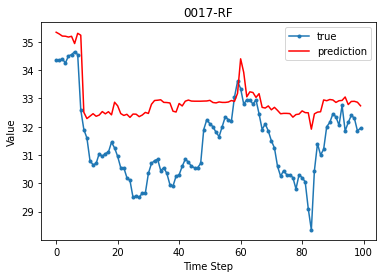

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('0017-RF')
plt.legend()
plt.show()

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.04902143219355915

In [20]:
mean_squared_error(y_val,y_val_pred,squared=False)

1.7288188484637361

In [21]:
r2_score(y_val,y_val_pred)

-0.6406800674927906